In [ ]:
!pip install --upgrade transformers==4.2

     |████████████████████████████████| 1.8MB 17.9MB/s 
     |████████████████████████████████| 2.9MB 49.3MB/s 
     |████████████████████████████████| 890kB 55.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a07bc13fdc1a213043d429f0bf6eef562a772028e3537c5daeba767631de646d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/webis.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

**Creating embedding for each premise**

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

embeddings = []

for premise in df['Premise'].to_list():
  inputs = tokenizer(premise, padding=True, truncation=True, return_tensors="pt", max_length=128)
  result = model(**inputs)
  embeddings.append(result.last_hidden_state[:, 0, :].detach().numpy())

In [ ]:
len(embeddings)

In [ ]:
test_embeddings = embeddings.copy()

**Flatten the array**

In [ ]:
import numpy as np
test_embeddings = np.concatenate(test_embeddings)

In [ ]:
print(test_embeddings)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_embeddings, df['Combined Quality'].to_list(), test_size=0.20, random_state=0)

**Best RMSE gotten with xgboost:**

In [ ]:
import xgboost
from sklearn.metrics import mean_squared_error
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_pred, y_test)
xgb_rmse = np.sqrt(xgb_mse)
# print(y_pred)
print('Xgboost RMSE: %.4f' % xgb_rmse)

[00:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost RMSE: 1.2726


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a74185588>]],
      dtype=object)

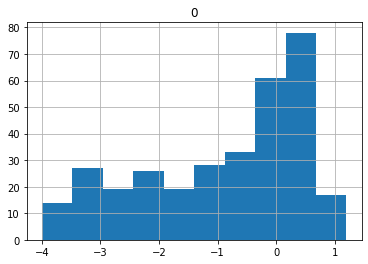

In [ ]:
pd.DataFrame(y_pred).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a7410a5f8>]],
      dtype=object)

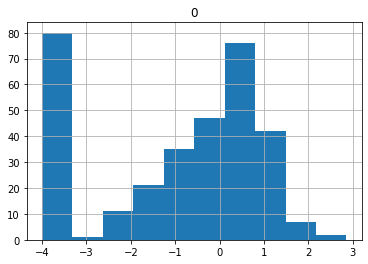

In [ ]:
pd.DataFrame(y_test).hist()

**Other estimators:**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_pred, y_test)
rf_rmse = np.sqrt(rf_mse)
print('RandomForest RMSE: %.4f' % rf_rmse)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
y_pred = est.predict(X_test)
est_mse = mean_squared_error(y_pred, y_test)
est_rmse = np.sqrt(est_mse)
print('Gradient boosting RMSE: %.4f' % est_rmse)

In [ ]:
from sklearn.linear_model import Ridge

rg= Ridge(alpha=.1)
rg.fit(X_train, y_train)
y_pred = rg.predict(X_test)
rg_mse = mean_squared_error(y_pred, y_test)
rg_rmse = np.sqrt(rg_mse)
print('Ridge RMSE: %.4f' % rg_rmse)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
svr = make_pipeline(StandardScaler(), SVR(C=12.0, epsilon=0.001,gamma = 1e-8))
# embeddings = embeddings.detach().numpy()
# embeddings_test = embeddings_test.detach().numpy()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(svr.score(X_test,y_test))
print(rmse)

In [ ]:
 xgb.save_model("xbg-model")